In [55]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pickle
from collections import deque
import torch.nn as nn
import gymnasium as gym
import torch.nn.functional as F
import torch.optim as optim
import random


In [56]:
class JobClassificationEnv(gym.Env):
    """Environnement personnalisé pour la classification des offres d'emploi"""
    metadata = {"render_modes": ["human"]}

    def __init__(self, features, labels):
        super(JobClassificationEnv, self).__init__()
        self.features = features
        self.labels = labels
        self.current_index = 0
        self.current_state = None
        
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(features.shape[1],), 
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(2)
        
    def reset(self, seed=None, options=None):
        if seed is not None:
            super().reset(seed=seed)
            
        if options is None:
            options = {}
            
        self.current_index = random.randint(0, len(self.features) - 1)
        self.current_state = self.features[self.current_index].astype(np.float32)
        
        return self.current_state, {}

    def step(self, action):
        reward = 1.0 if action == self.labels[self.current_index] else -1.0
        done = True
        truncated = False
        info = {}
        return self.current_state, reward, done, truncated, info

    def render(self, mode="human"):
        pass

In [57]:
X_train = np.load('../Data/X_train.npy')
y_train = np.load('../Data/y_train.npy')
X_test = np.load('../Data/X_test.npy')
y_test = np.load('../Data/y_test.npy')

In [58]:
with open('../Data/train_env.pkl', 'rb') as f:
    train_env = pickle.load(f)
with open('../Data/test_env.pkl', 'rb') as f:
    test_env = pickle.load(f)

In [59]:
class DQNAgent:
    """Agent utilisant un DQN avec replay memory et exploration epsilon-greedy"""
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        
        self.losses = []
        self.rewards = []
        self.epsilons = []
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            act_values = self.model(state_tensor)
            return torch.argmax(act_values[0]).item()
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return 0
        
        minibatch = random.sample(self.memory, batch_size)
        total_loss = 0
        
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            
            target = reward
            if not done:
                with torch.no_grad():
                    target = reward + self.gamma * torch.max(self.model(next_state_tensor)[0]).item()
            
            current_q = self.model(state_tensor)[0]
            target_f = current_q.clone()
            target_f[action] = target
            
            self.optimizer.zero_grad()
            loss = self.criterion(current_q, target_f)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        avg_loss = total_loss / batch_size
        self.losses.append(avg_loss)
        return avg_loss
    
    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        ax1.plot(self.losses)
        ax1.set_title('Évolution de la perte pendant l\'entraînement')
        ax1.set_xlabel('Mini-batch')
        ax1.set_ylabel('Perte (MSE)')
        ax1.grid(True)
        
        ax2.plot(self.epsilons, label='Epsilon')
        if self.rewards:
            window_size = min(50, len(self.rewards))
            smoothed_rewards = np.convolve(self.rewards, np.ones(window_size)/window_size, mode='valid')
            ax2.plot(smoothed_rewards, label='Récompense moyenne (lissée)')
        
        ax2.set_title('Évolution de l\'exploration et des récompenses')
        ax2.set_xlabel('Épisode')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig('../Data/training_metrics.png')
        plt.show()
    
    def load(self, name):
        self.model.load_state_dict(torch.load(name))
    
    def save(self, name):
        torch.save(self.model.state_dict(), name)

In [60]:
state_size = X_train.shape[1]
action_size = 2
agent = DQNAgent(state_size, action_size)
agent.load('../Data/initial_dqn_model.pth')

 Paramètres d'entraînement

In [61]:
batch_size = 32
EPISODES = 1000
episode_rewards = []
print(f"Nombre d'épisodes: {EPISODES}")
print(f"Taille du batch: {batch_size}")

Nombre d'épisodes: 1000
Taille du batch: 32


Boucle d'entraînement

In [62]:
for e in range(EPISODES):
    state, _ = train_env.reset()
    done = False
    episode_reward = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done, truncated, _ = train_env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

    loss = agent.replay(batch_size)
    agent.epsilons.append(agent.epsilon)
    agent.rewards.append(episode_reward)

    if (e + 1) % 100 == 0:
        print(f"Épisode: {e+1}/{EPISODES}, Epsilon: {agent.epsilon:.2f}, Perte: {loss:.4f}")


Épisode: 100/1000, Epsilon: 0.71, Perte: 0.0032
Épisode: 200/1000, Epsilon: 0.43, Perte: 0.0068
Épisode: 300/1000, Epsilon: 0.26, Perte: 0.0002
Épisode: 400/1000, Epsilon: 0.16, Perte: 0.0001
Épisode: 500/1000, Epsilon: 0.10, Perte: 0.0007
Épisode: 600/1000, Epsilon: 0.06, Perte: 0.0006
Épisode: 700/1000, Epsilon: 0.03, Perte: 0.0005
Épisode: 800/1000, Epsilon: 0.02, Perte: 0.0012
Épisode: 900/1000, Epsilon: 0.01, Perte: 0.0004
Épisode: 1000/1000, Epsilon: 0.01, Perte: 0.0004


Visualisation des métriques

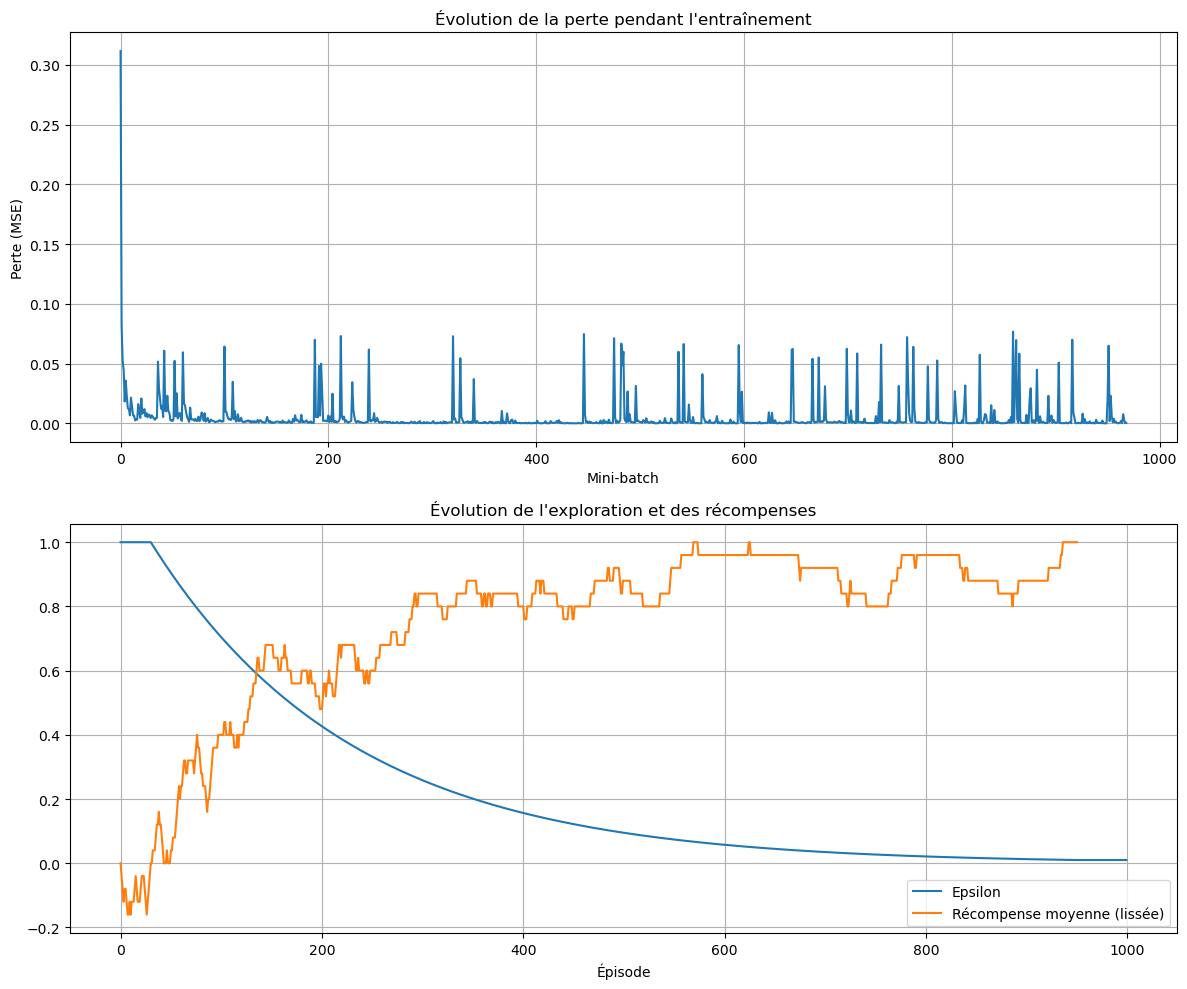

In [63]:
agent.plot_metrics()

Évaluation du modèle

In [64]:
def evaluate_model(agent, test_env, X_test, y_test):
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    agent.epsilon = 0.0

    for i in range(len(X_test)):
        state = X_test[i]
        true_label = y_test[i]
        action = agent.act(state)
        all_labels.append(true_label)
        all_preds.append(action)
        
        if action == true_label:
            correct += 1
        total += 1

    accuracy = correct / total
    print(f"Précision du modèle sur le jeu de test: {accuracy*100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Authentique', 'Frauduleuse'], 
                yticklabels=['Authentique', 'Frauduleuse'])
    plt.title('Matrice de confusion')
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')
    plt.savefig('../Data/confusion_matrix.png')
    plt.show()

Précision du modèle sur le jeu de test: 95.92%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3403
           1       0.91      0.17      0.29       173

    accuracy                           0.96      3576
   macro avg       0.93      0.59      0.64      3576
weighted avg       0.96      0.96      0.95      3576



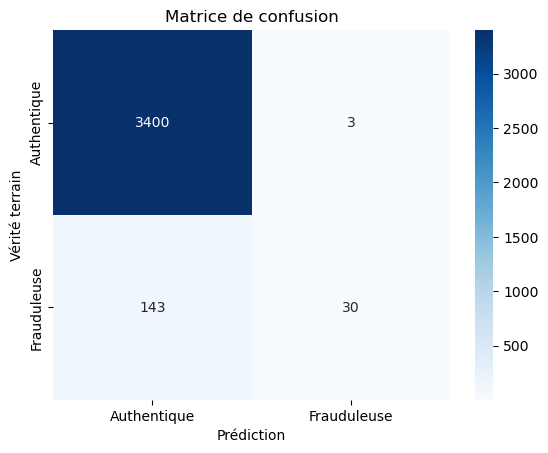

In [65]:
evaluate_model(agent, test_env, X_test, y_test)

In [66]:
agent.save('../Data/fake_job_dqn_model.pth')